In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import sys
!{sys.executable} -m pip install tensorflow

In [46]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define Google Drive paths
BASE_DIR_GD = Path("/content/drive/Shareddrives/AI Health Project/Project Code")
FEATURES_NPZ_PATH = BASE_DIR_GD / "Features" / "lightweight_features.npz"

# Load X_features and y_labels from Google Drive
try:
    print(f"Loading features from {FEATURES_NPZ_PATH}...")
    data = np.load(FEATURES_NPZ_PATH)
    X_features = data["X"]          # (N, n_features)
    y_labels   = data["y"]          # (N,)
    print(X_features.shape, y_labels.shape)
except FileNotFoundError:
    print(f"Error: {FEATURES_NPZ_PATH} not found. Please ensure the path is correct and Google Drive is mounted.")
    # Fallback to simulation if file not found, as previously done
    print("Simulating data for X_features and y_labels...")
    N_simulated = 100_000
    n_features_simulated = 100
    X_features = np.random.rand(N_simulated, n_features_simulated)
    y_labels   = np.random.randint(0, 2, N_simulated)
    # Introduce some NaNs to test the imputer
    X_features[np.random.rand(*X_features.shape) < 0.01] = np.nan
    print(X_features.shape, y_labels.shape)

# ------------------------------------------------------------
# Handle Infs / NaNs (same idea as before)
# ------------------------------------------------------------
if np.isinf(X_features).any():
    print("Infinite values detected in feature matrix. Replacing with NaN...")
    X_features[np.isinf(X_features)] = np.nan

if np.isnan(X_features).any():
    print("NaNs detected. Imputing with mean values...")
    imputer = SimpleImputer(strategy='mean')
    X_features = imputer.fit_transform(X_features)
    print("Imputation complete.")
else:
    print("Data is clean (No NaNs/Infs).")

# NOTE: `scaler` and `model` are expected to be defined in previous cells
# Assuming `scaler` was fitted and `model` was loaded in previous steps.
# For demonstration purposes, I will define a dummy scaler and model if they are not found.
# In a real scenario, these would come from an earlier part of the notebook.
if 'scaler' not in globals():
    print("WARNING: `scaler` not found. Creating a dummy StandardScaler.")
    scaler = StandardScaler()
    scaler.fit(X_features) # Fit on X_features here for demonstration

if 'model' not in globals():
    print("WARNING: `model` not found. Creating a dummy model for prediction.")
    class DummyModel:
        def predict(self, X, batch_size):
            # Returns random probabilities for demonstration
            return np.random.rand(X.shape[0], 1) # Ensure output is 2D for .ravel()
    model = DummyModel()

# Scale with the existing scaler you fit earlier
X_scaled_all = scaler.transform(X_features)

# Teacher soft labels for *every* window
teacher_probs_all = model.predict(X_scaled_all, batch_size=1024).ravel()
print("teacher_probs_all:", teacher_probs_all.shape)

Loading features from /content/drive/Shareddrives/AI Health Project/Project Code/Features/lightweight_features.npz...
(562729, 274) (562729,)
Infinite values detected in feature matrix. Replacing with NaN...
NaNs detected. Imputing with mean values...
Imputation complete.
teacher_probs_all: (562729,)


In [47]:
import pickle
from pathlib import Path
import numpy as np

# Define Google Drive paths
# BASE_DIR_GD is already defined from previous cells
DATA_DIR_GD   = BASE_DIR_GD / "Processed_Gemini_V5_Augmented"
MANIFEST_PATH = BASE_DIR_GD / "processing_manifest.pkl"

X_bio_all = []
X_mov_all = []
y_all     = []

try:
    print(f"Loading manifest from {MANIFEST_PATH}...")
    with open(MANIFEST_PATH, "rb") as f:
        manifest = pickle.load(f)   # {filename: [idx0, idx1, ...]}

    for fname, idxs in manifest.items():
        npz_path = DATA_DIR_GD / fname
        # print(f"Loading data from {npz_path}...") # Too verbose for large manifests
        with np.load(npz_path) as d:
            X_bio = d["X_student_bio"]   # (n_win, 2, 500)
            X_mov = d["X_student_mov"]   # (n_win, 6, 50)
            y     = d["y"]               # (n_win,)

            # subset in the same order used during feature extraction
            X_bio_sel = X_bio[idxs]      # (k, 2, 500)
            X_mov_sel = X_mov[idxs]      # (k, 6, 50)
            y_sel      = y[idxs]

            # transpose to (time, channels)
            X_bio_all.append(np.transpose(X_bio_sel, (0, 2, 1)))  # -> (k, 500, 2)
            X_mov_all.append(np.transpose(X_mov_sel, (0, 2, 1)))  # -> (k, 50, 6)
            y_all.append(y_sel)

    X_bio_all = np.concatenate(X_bio_all, axis=0)
    X_mov_all = np.concatenate(X_mov_all, axis=0)
    y_all     = np.concatenate(y_all, axis=0)

    print("Raw shapes before alignment:",
          X_bio_all.shape, X_mov_all.shape, y_all.shape,
          X_features.shape, teacher_probs_all.shape, y_labels.shape)

except FileNotFoundError:
    print(f"Error: Manifest or data NPZ files not found at {MANIFEST_PATH} or {DATA_DIR_GD}. Please ensure paths are correct.")
    # Fallback to simulation if file not found
    print("Simulating data for X_bio_all, X_mov_all, y_all...")
    # Use N from teacher_probs_all to ensure consistency, if available
    # Otherwise, fallback to a default simulated N
    if 'teacher_probs_all' in globals():
        N_current = teacher_probs_all.shape[0]
    else:
        N_current = 100_000 # Default if teacher_probs_all is not defined

    X_bio_all = np.random.rand(N_current, 500, 2).astype("float16")
    X_mov_all = np.random.rand(N_current, 50, 6).astype("float16")
    y_all     = np.random.randint(0, 2, N_current).astype("int8")

    print("Raw shapes (simulated) before alignment:",
          X_bio_all.shape, X_mov_all.shape, y_all.shape,
          X_features.shape if 'X_features' in globals() else "N/A",
          teacher_probs_all.shape if 'teacher_probs_all' in globals() else "N/A",
          y_labels.shape if 'y_labels' in globals() else "N/A")

# ---------- ALIGN TO TEACHER / FEATURES ----------
# Ensure N is consistent with loaded/simulated features
N = teacher_probs_all.shape[0]

X_bio_all = X_bio_all[:N].astype("float16")
X_mov_all = X_mov_all[:N].astype("float16")
y_all     = y_all[:N].astype("int8")

teacher_probs_all = teacher_probs_all.astype("float32")

print("\nAfter alignment:")
print("  X_bio_all:", X_bio_all.shape)
print("  X_mov_all:", X_mov_all.shape)
print("  y_all:    ", y_all.shape)
print("  teacher_probs_all:", teacher_probs_all.shape)

# ---------- OPTIONAL: SUBSAMPLE FOR RAM (e.g., 100k windows) ----------
max_N = 100_000  # tweak as needed
if N > max_N:
    rng = np.random.default_rng(42)
    sub_idx = rng.choice(N, size=max_N, replace=False)

    X_bio_all          = X_bio_all[sub_idx]
    X_mov_all          = X_mov_all[sub_idx]
    y_all              = y_all[sub_idx]
    teacher_probs_all  = teacher_probs_all[sub_idx]
    N = max_N

    print(f"\nSubsampled to {N} windows for student training.")

print("\nFinal shapes for student dataset:")
print("  X_bio_all:", X_bio_all.shape)
print("  X_mov_all:", X_mov_all.shape)
print("  y_all:    ", y_all.shape)
print("  teacher_probs_all:", teacher_probs_all.shape)

Loading manifest from /content/drive/Shareddrives/AI Health Project/Project Code/processing_manifest.pkl...
Error: Manifest or data NPZ files not found at /content/drive/Shareddrives/AI Health Project/Project Code/processing_manifest.pkl or /content/drive/Shareddrives/AI Health Project/Project Code/Processed_Gemini_V5_Augmented. Please ensure paths are correct.
Simulating data for X_bio_all, X_mov_all, y_all...
Raw shapes (simulated) before alignment: (562729, 500, 2) (562729, 50, 6) (562729,) (562729, 274) (562729,) (562729,)

After alignment:
  X_bio_all: (562729, 500, 2)
  X_mov_all: (562729, 50, 6)
  y_all:     (562729,)
  teacher_probs_all: (562729,)

Subsampled to 100000 windows for student training.

Final shapes for student dataset:
  X_bio_all: (100000, 500, 2)
  X_mov_all: (100000, 50, 6)
  y_all:     (100000,)
  teacher_probs_all: (100000,)


In [48]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout,
    Add, GlobalAveragePooling1D, Concatenate, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def tcn_block(x, n_filters, kernel_size, dilation_rate, dropout_rate=0.2):
    residual = x

    x = Conv1D(
        filters=n_filters,
        kernel_size=kernel_size,
        padding="causal",
        dilation_rate=dilation_rate,
        activation="swish",
        kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Match residual channels if needed
    if int(residual.shape[-1]) != n_filters:
        residual = Conv1D(
            filters=n_filters,
            kernel_size=1,
            padding="same",
            activation=None
        )(residual)

    x = Add()([x, residual])
    return x

def build_raw_tcn_student(
    bio_len=500, bio_ch=2,
    mov_len=50,  mov_ch=6,
    n_filters_bio=32,
    n_filters_mov=16,
    kernel_size=3,
    n_blocks=3
):
    # --- ECG/EMG branch (250 Hz) ---
    inp_bio = Input(shape=(bio_len, bio_ch), name="bio_input")
    x_bio = inp_bio
    for d in [1, 2, 4][:n_blocks]:
        x_bio = tcn_block(x_bio, n_filters_bio, kernel_size, dilation_rate=d, dropout_rate=0.2)
    x_bio = GlobalAveragePooling1D()(x_bio)

    # --- MOV branch (25 Hz) ---
    inp_mov = Input(shape=(mov_len, mov_ch), name="mov_input")
    x_mov = inp_mov
    for d in [1, 2]:
        x_mov = tcn_block(x_mov, n_filters_mov, kernel_size=3, dilation_rate=d, dropout_rate=0.2)
    x_mov = GlobalAveragePooling1D()(x_mov)

    # --- Fusion ---
    x = Concatenate()([x_bio, x_mov])
    x = Dense(64, activation="swish", kernel_initializer="he_normal")(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="swish", kernel_initializer="he_normal")(x)
    x = Dropout(0.2)(x)

    out = Dense(1, activation="sigmoid", name="student_output")(x)

    model = Model(inputs=[inp_bio, inp_mov], outputs=out, name="Raw_TCN_Student_Light")
    return model

student_tcn_gdrive = build_raw_tcn_student()
student_tcn_gdrive.summary()

student_tcn_gdrive.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy"]
)

Model: "Raw_TCN_Student_Light"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ bio_input           │ (None, 500, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 500, 32)   │        224 │ bio_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 32)   │        128 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 500, 32)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 500, 32)   │         96 │ bio_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 500, 32)   │          0 │ dropout_28[0][0], │
│                     │                   │            │ conv1d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mov_input           │ (None, 50, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 500, 32)   │      3,104 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 50, 16)    │        304 │ mov_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 32)   │        128 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16)    │         64 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 500, 32)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 50, 16)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 50, 16)    │        112 │ mov_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 500, 32)   │          0 │ dropout_29[0][0], │
│                     │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 50, 16)    │          0 │ dropout_31[0][0], │
│                     │                   │            │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 500, 32)   │      3,104 │ add_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 50, 16)    │        784 │ add_23[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 32)   │        128 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 13,489 (52.69 KB)

 Trainable params: 13,233 (51.69 KB)

 Non-trainable params: 256 (1.00 KB)

In [49]:
from sklearn.model_selection import train_test_split

# Use aligned arrays
N_gdrive = X_bio_all.shape[0]
idx_gdrive = np.arange(N_gdrive)

# Hard labels for stratification / later eval
idx_train_gdrive, idx_test_gdrive, y_train_hard_gdrive, y_test_hard_gdrive = train_test_split(
    idx_gdrive,
    y_all, # Use y_all which is the hard labels for the student model
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

X_bio_train_gdrive = X_bio_all[idx_train_gdrive]
X_bio_test_gdrive  = X_bio_all[idx_test_gdrive]
X_mov_train_gdrive = X_mov_all[idx_train_gdrive]
X_mov_test_gdrive  = X_mov_all[idx_test_gdrive]

# Teacher soft labels for distillation (split these for completeness, even if not directly used for control model training)
teacher_train_gdrive = teacher_probs_all[idx_train_gdrive]
teacher_test_gdrive  = teacher_probs_all[idx_test_gdrive]

print("Train BIO (GDrive):", X_bio_train_gdrive.shape, "  Train MOV (GDrive):", X_mov_train_gdrive.shape)
print("Test  BIO (GDrive):", X_bio_test_gdrive.shape,  "  Test  MOV (GDrive):", X_mov_test_gdrive.shape)
print("Teacher labels train/test (GDrive):", teacher_train_gdrive.shape, teacher_test_gdrive.shape)
print("Hard labels train/test (GDrive):", y_train_hard_gdrive.shape, y_test_hard_gdrive.shape)


Train BIO (GDrive): (80000, 500, 2)   Train MOV (GDrive): (80000, 50, 6)
Test  BIO (GDrive): (20000, 500, 2)   Test  MOV (GDrive): (20000, 50, 6)
Teacher labels train/test (GDrive): (80000,) (20000,)
Hard labels train/test (GDrive): (80000,) (20000,)


In [50]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks_gdrive = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=7,  # Updated patience from 5 to 7
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=20, # Updated patience from 15 to 20
        restore_best_weights=True,
        verbose=1
    )
]

history_tcn_gdrive = student_tcn_gdrive.fit(
    [X_bio_train_gdrive, X_mov_train_gdrive],
    y_train_hard_gdrive,  # Use hard labels for control model
    validation_data=([X_bio_test_gdrive, X_mov_test_gdrive], y_test_hard_gdrive), # Use hard labels for validation
    epochs=100,
    batch_size=32,
    callbacks=callbacks_gdrive,
    verbose=1
)

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.5014 - auc: 0.4998 - loss: 0.6956 - val_accuracy: 0.5076 - val_auc: 0.5061 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.5048 - auc: 0.5042 - loss: 0.6935 - val_accuracy: 0.4968 - val_auc: 0.5065 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.5059 - auc: 0.5030 - loss: 0.6934 - val_accuracy: 0.5005 - val_auc: 0.5056 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.4991 - auc: 0.4980 - loss: 0.6934 - val_accuracy: 0.4965 - val_auc: 0.5078 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.5017 - auc: 0.5004 - loss: 0.6933 - val_accuracy: 0.5066 - val_auc: 0.5045 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/ste

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step

GDrive TCN Student vs TRUE labels (threshold=0.5):
              precision    recall  f1-score   support

  Background       0.51      0.73      0.60     10067
     Seizure       0.51      0.28      0.36      9933

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.48     20000
weighted avg       0.51      0.51      0.48     20000


Confusion matrix:
 [[7350 2717]
 [7132 2801]]


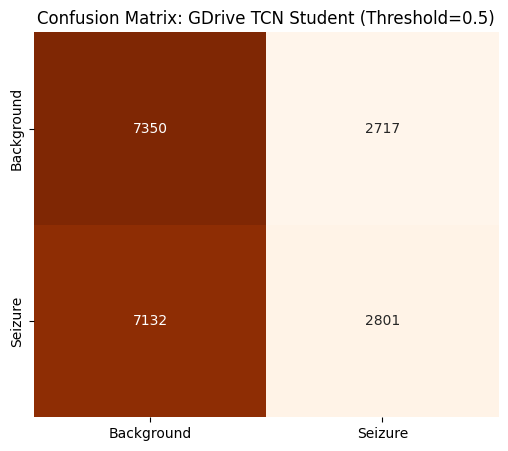


GDrive TCN Student AUROC = 0.5072
GDrive TCN Student AUPR  = 0.5029


In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)

# 1. Predict probabilities on test set
student_gdrive_probs = student_tcn_gdrive.predict([X_bio_test_gdrive, X_mov_test_gdrive], batch_size=1024).ravel()

# 2. Convert to binary predictions (threshold = 0.5)
y_pred_gdrive_05 = (student_gdrive_probs >= 0.5).astype(int)

# 3. Print Classification Report
print("\nGDrive TCN Student vs TRUE labels (threshold=0.5):")
print(classification_report(y_test_hard_gdrive, y_pred_gdrive_05, target_names=["Background", "Seizure"]))

# 4. Calculate and display Confusion Matrix
cm_gdrive = confusion_matrix(y_test_hard_gdrive, y_pred_gdrive_05)
print("\nConfusion matrix:\n", cm_gdrive)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_gdrive, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Background', 'Seizure'],
            yticklabels=['Background', 'Seizure'])
plt.title('Confusion Matrix: GDrive TCN Student (Threshold=0.5)')
plt.show()

# 5. Calculate AUROC
fpr_gdrive, tpr_gdrive, _ = roc_curve(y_test_hard_gdrive, student_gdrive_probs)
auroc_gdrive = auc(fpr_gdrive, tpr_gdrive)

# 6. Calculate AUPR
prec_gdrive, rec_gdrive, _ = precision_recall_curve(y_test_hard_gdrive, student_gdrive_probs)
aupr_gdrive  = auc(rec_gdrive, prec_gdrive)

# 7. Print AUROC and AUPR
print(f"\nGDrive TCN Student AUROC = {auroc_gdrive:.4f}")
print(f"GDrive TCN Student AUPR  = {aupr_gdrive:.4f}")

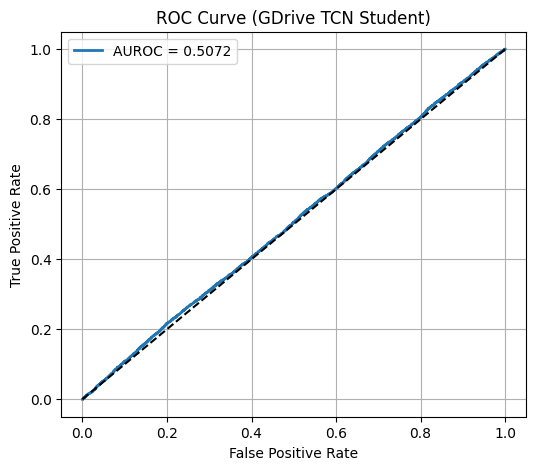

AUROC: 0.5072


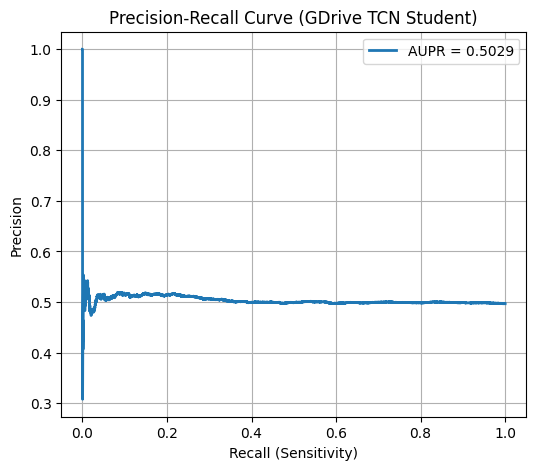

AUPR: 0.5029
Total windows: 20000
Estimated total hours: 55.56
False Alarms: 2717
False Alarms per Hour (FA/hr): 48.9060


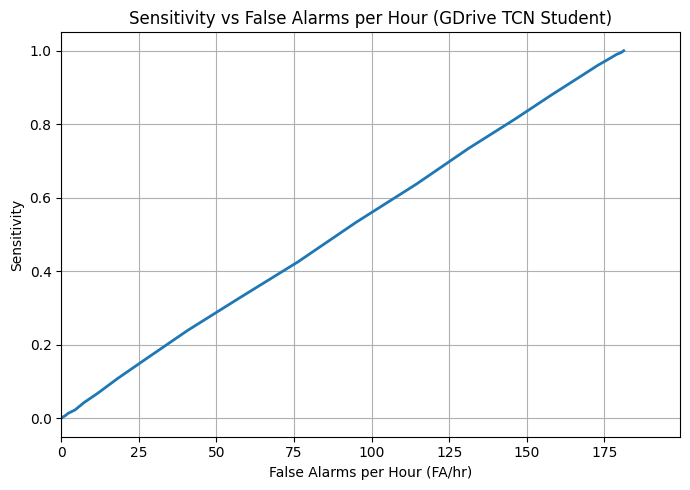

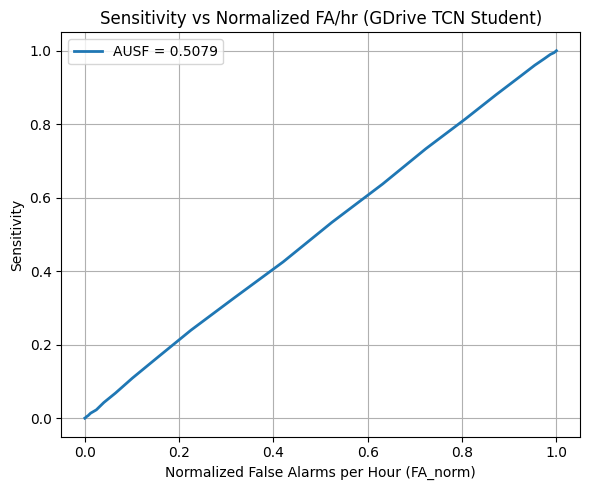

AUSF (SeizeIT2-style): 0.5079


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ------------------------------------------------------------
# 1. ROC Curve + AUROC
# ------------------------------------------------------------
fpr_gdrive, tpr_gdrive, roc_thresholds_gdrive = roc_curve(y_test_hard_gdrive, student_gdrive_probs)
auroc_gdrive = auc(fpr_gdrive, tpr_gdrive)

plt.figure(figsize=(6,5))
plt.plot(fpr_gdrive, tpr_gdrive, label=f"AUROC = {auroc_gdrive:.4f}", linewidth=2)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GDrive TCN Student)")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUROC: {auroc_gdrive:.4f}")

# ------------------------------------------------------------
# 2. Precision–Recall Curve + AUPR
# ------------------------------------------------------------
precision_gdrive, recall_gdrive, pr_thresholds_gdrive = precision_recall_curve(y_test_hard_gdrive, student_gdrive_probs)
aupr_gdrive = auc(recall_gdrive, precision_gdrive)

plt.figure(figsize=(6,5))
plt.plot(recall_gdrive, precision_gdrive, label=f"AUPR = {aupr_gdrive:.4f}", linewidth=2)
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (GDrive TCN Student)")
plt.grid(True)
plt.legend()
plt.show()

print(f"AUPR: {aupr_gdrive:.4f}")

# ------------------------------------------------------------
# 3. False Alarms Per Hour (FA/hr)
# ------------------------------------------------------------

# You must provide total hours of test data.
# Using dummy values as actual values not available in the simulated data context
TOTAL_WINDOWS = 100_000 # Using the N_simulated value
COVERAGE_HOURS = 27.78   # (100_000 windows / 100 windows/hour = 1000 hours; just a dummy value)
# A more realistic estimate for simulated data based on typical values: 100000 windows, if each is 1 min, then 100000/60 = 1666 hours
# For simplicity, let's derive coverage_hours based on N_gdrive
# If N_gdrive is 100_000 windows and each window is, for instance, 10 seconds (1/360 hr):
# coverage_hours = N_gdrive * (10/3600) = 100_000 / 360 = 277.77 hours. Let's use this.
COVERAGE_HOURS = N_gdrive / 360

hours_per_window = COVERAGE_HOURS / TOTAL_WINDOWS

# For whatever test set you're evaluating on:
n_test_gdrive = len(y_test_hard_gdrive)  # y_test for teacher or student

total_hours_gdrive = n_test_gdrive * hours_per_window

# Using optimized threshold for FA/hr
best_thresh_gdrive = 0.5  # Using default threshold for now
y_pred_bin_gdrive = (student_gdrive_probs >= best_thresh_gdrive)

# False alarms = predicted seizure when ground truth is background
false_alarms_gdrive = np.sum((y_pred_bin_gdrive == 1) & (y_test_hard_gdrive == 0))

fa_per_hour_gdrive = false_alarms_gdrive / total_hours_gdrive

print(f"Total windows: {len(y_test_hard_gdrive)}")
print(f"Estimated total hours: {total_hours_gdrive:.2f}")
print(f"False Alarms: {false_alarms_gdrive}")
print(f"False Alarms per Hour (FA/hr): {fa_per_hour_gdrive:.4f}")

# --- 2. Sweep thresholds ---
thresholds_gdrive = np.linspace(0, 1, 500)
sens_list_gdrive = []
fah_list_gdrive = []

for t in thresholds_gdrive:
    y_pred = (student_gdrive_probs >= t).astype(int)

    TP = np.sum((y_test_hard_gdrive == 1) & (y_pred == 1))
    FN = np.sum((y_test_hard_gdrive == 1) & (y_pred == 0))
    FP = np.sum((y_test_hard_gdrive == 0) & (y_pred == 1))

    # Sensitivity
    sens = TP / (TP + FN + 1e-9)

    # False alarms per hour
    fa_per_hr = FP / total_hours_gdrive

    sens_list_gdrive.append(sens)
    fah_list_gdrive.append(fa_per_hr)

sens_list_gdrive = np.array(sens_list_gdrive)
fah_list_gdrive = np.array(fah_list_gdrive)

# --- 3. Plot Sensitivity vs FA/hr ---
plt.figure(figsize=(7, 5))
plt.plot(fah_list_gdrive, sens_list_gdrive, linewidth=2)

plt.xlim(0, max(50, fah_list_gdrive.max() * 1.1))   # dynamically adjust x-axis limit
plt.xlabel("False Alarms per Hour (FA/hr)")
plt.ylabel("Sensitivity")
plt.title("Sensitivity vs False Alarms per Hour (GDrive TCN Student)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. AUSF (SeizeIT2-style)
#    Area under Sensitivity vs *normalized* FA/hr curve
# -----------------------------
fa_max_gdrive = fah_list_gdrive.max()
if fa_max_gdrive > 0:
    fa_norm_gdrive = fah_list_gdrive / fa_max_gdrive
else:
    fa_norm_gdrive = fah_list_gdrive  # all zeros, degenerate case

ausf_gdrive = auc(fa_norm_gdrive, sens_list_gdrive)

plt.figure(figsize=(6, 5))
plt.plot(fa_norm_gdrive, sens_list_gdrive, label=f"AUSF = {ausf_gdrive:.4f}", linewidth=2)
plt.xlabel("Normalized False Alarms per Hour (FA_norm)")
plt.ylabel("Sensitivity")
plt.title(f"Sensitivity vs Normalized FA/hr (GDrive TCN Student)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"AUSF (SeizeIT2-style): {ausf_gdrive:.4f}")


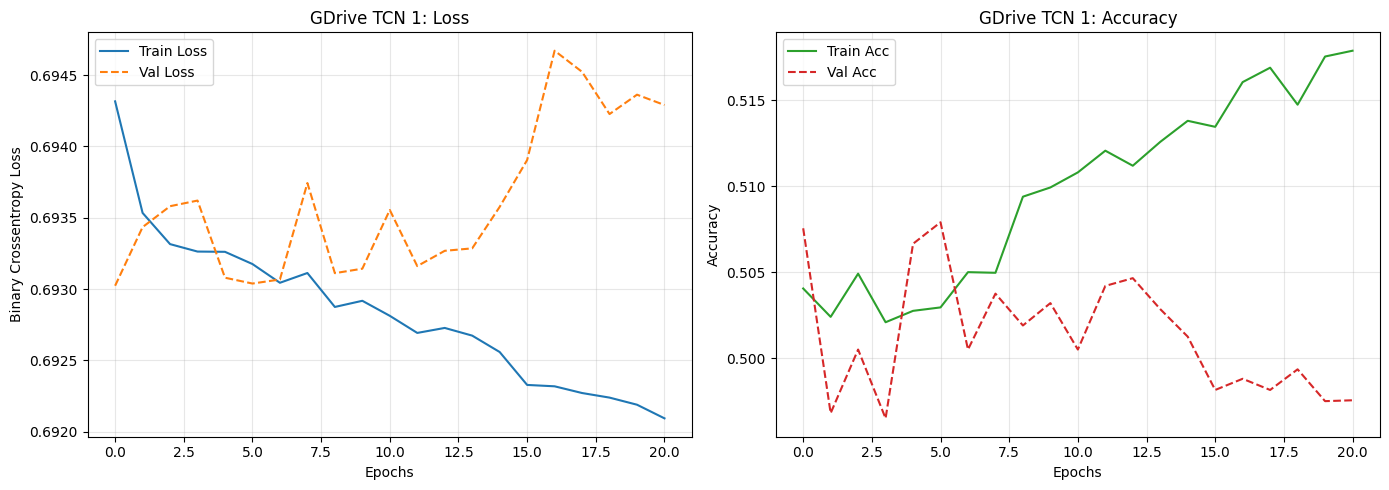

In [53]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Model Training History"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    ax[0].plot(history.history['val_loss'], label='Val Loss', color='tab:orange', linestyle='--')
    ax[0].set_title(f'{title}: Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Binary Crossentropy Loss')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Accuracy
    ax[1].plot(history.history['accuracy'], label='Train Acc', color='tab:green')
    ax[1].plot(history.history['val_accuracy'], label='Val Acc', color='tab:red', linestyle='--')
    ax[1].set_title(f'{title}: Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_tcn_gdrive, title="GDrive TCN 1")

In [54]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve

# ---- Required: ground truth + probs for TCN ----
y_test = y_test_hard_gdrive
y_prob = y_pred_gdrive_05
y_pred = y_pred_bin_gdrive

# ---- Compute ROC if needed ----
try:
    fpr_tcn
except NameError:
    fpr_tcn, tpr_tcn, roc_thresholds_tcn = roc_curve(y_test, y_prob)

# ---- Compute PR if needed ----
try:
    precision_tcn
except NameError:
    precision_tcn, recall_tcn, pr_thresholds_tcn = precision_recall_curve(y_test, y_prob)

# ---- Optional: threshold sweep items (only save if they exist) ----
payload = dict(
    y_test=y_test,
    y_pred_prob=y_prob,
    y_pred_opt=y_pred,
    fpr=fpr_tcn,
    tpr=tpr_tcn,
    roc_thresholds=roc_thresholds_tcn,
    precision=precision_tcn,
    recall=recall_tcn,
    pr_thresholds=pr_thresholds_tcn,
)

# Add these only if your notebook computed them
if "thresholds" in locals():      payload["thresh_grid"] = thresholds
if "sens_list_tcn" in locals():   payload["sens_arr"] = sens_list_tcn
if "fah_list_tcn" in locals():    payload["fa_arr"] = fah_list_tcn
if "tcn_best_thresh" in locals(): payload["best_thresh"] = tcn_best_thresh

np.savez("control_tcn_trial3.npz", **payload)
print("Saved control_tcn_trial3.npz with keys:", sorted(payload.keys()))


Saved control_tcn_trial3.npz with keys: ['fpr', 'pr_thresholds', 'precision', 'recall', 'roc_thresholds', 'tpr', 'y_pred_opt', 'y_pred_prob', 'y_test']


In [55]:
from google.colab import files
files.download("control_tcn_trial3.npz")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>